In [1]:
from model import *
import mesa
import pandas as pd
import seaborn as sns

In [10]:
model = HousingMarket()
model.run_model(100)

data = model.datacollector.get_agent_vars_dataframe()

In [11]:
data

Income          Price   Age
Step AgentID                                  
1    1                NaN  251228.906427   NaN
     2                NaN  606954.567816   NaN
     3                NaN  237143.822721   NaN
     4                NaN  412924.281695   NaN
     5                NaN  473517.877829   NaN
...                   ...            ...   ...
100  251       832.924428            NaN  27.0
     252       487.810679            NaN  25.0
     253      1155.211075            NaN  23.0
     254       502.206796            NaN  20.0
     255      1417.831536            NaN  20.0

[24995 rows x 3 columns]

In [23]:
data["Age"].loc[100]

AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
251    27.0
252    25.0
253    23.0
254    20.0
255    20.0
Name: Age, Length: 250, dtype: float64

In [19]:
data["Age"][100]

AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
251    27.0
252    25.0
253    23.0
254    20.0
255    20.0
Name: Age, Length: 250, dtype: float64

<AxesSubplot:ylabel='Count'>

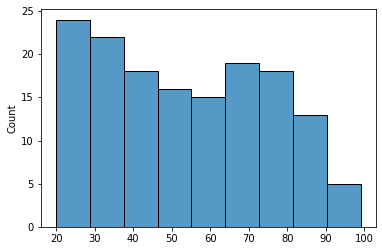

In [21]:
from collections import Counter

ages = []
for i in range(len(data["Age"][100])):
    ages.append(data["Age"].iloc[i])
    
min(ages)
max(ages)

sns.histplot(ages)

<AxesSubplot:ylabel='Count'>

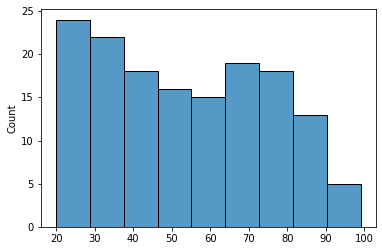

In [22]:
from collections import Counter

ages = []
for i in range(len(data["Age"][1])):
    ages.append(data["Age"].iloc[i])
    
min(ages)
max(ages)

sns.histplot(ages)

In [25]:
data["Age"].loc[1]

AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64

In [26]:
data["Age"].loc[2]

AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64

In [27]:
data["Age"].loc[3]

AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64

In [31]:
for i in range(1,15):
    print(i)
    print(data["Age"].loc[i])

1
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64
2
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64
3
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64
4
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64
5
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
247    27.0
248    20.0
249    47.0
250    26.0
Name: Age, Length: 250, dtype: float64
6
AgentID
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
246    44.0
2

In [33]:
data["Age"]

Step  AgentID
1     1           NaN
      2           NaN
      3           NaN
      4           NaN
      5           NaN
                 ... 
100   251        27.0
      252        25.0
      253        23.0
      254        20.0
      255        20.0
Name: Age, Length: 24995, dtype: float64

In [41]:
data.columns

Index(['Income', 'Price', 'Age'], dtype='object')

In [42]:
data["AgentID"]

KeyError: 'AgentID'

In [45]:
data.xs(1, level = "AgentID")

,Income,Price,Age
Step,,,
1,NaN,251228.906427,NaN
2,NaN,251228.906427,NaN
3,NaN,251228.906427,NaN
4,NaN,251228.906427,NaN
5,NaN,251228.906427,NaN
...,...,...,...
96,NaN,246836.335537,NaN
97,NaN,237822.034802,NaN
98,NaN,237822.034802,NaN


In [51]:
data.xs(15, level = "Step")[200:255]

,Income,Price,Age
AgentID,,,
202,3140.126878,NaN,65.0
203,1345.025887,NaN,82.0
204,5614.120012,NaN,70.0
205,3063.300218,NaN,79.0
206,2255.349817,NaN,93.0
207,4557.479802,NaN,30.0
208,1828.421510,NaN,29.0
209,5073.763198,NaN,75.0
210,1093.494878,NaN,21.0


In [50]:
data.xs(1, level = "Step")[200:255]

,Income,Price,Age
AgentID,,,
201,1675.930075,NaN,51.0
202,3140.126878,NaN,64.0
203,1345.025887,NaN,81.0
204,5614.120012,NaN,69.0
205,3063.300218,NaN,78.0
206,2255.349817,NaN,92.0
207,4557.479802,NaN,29.0
208,1828.421510,NaN,28.0
209,5073.763198,NaN,74.0
